In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, TopKPooling
from torch_geometric.data import Data,DataLoader
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

from scipy import sparse

# load pickle module
import pickle
import networkx as nx

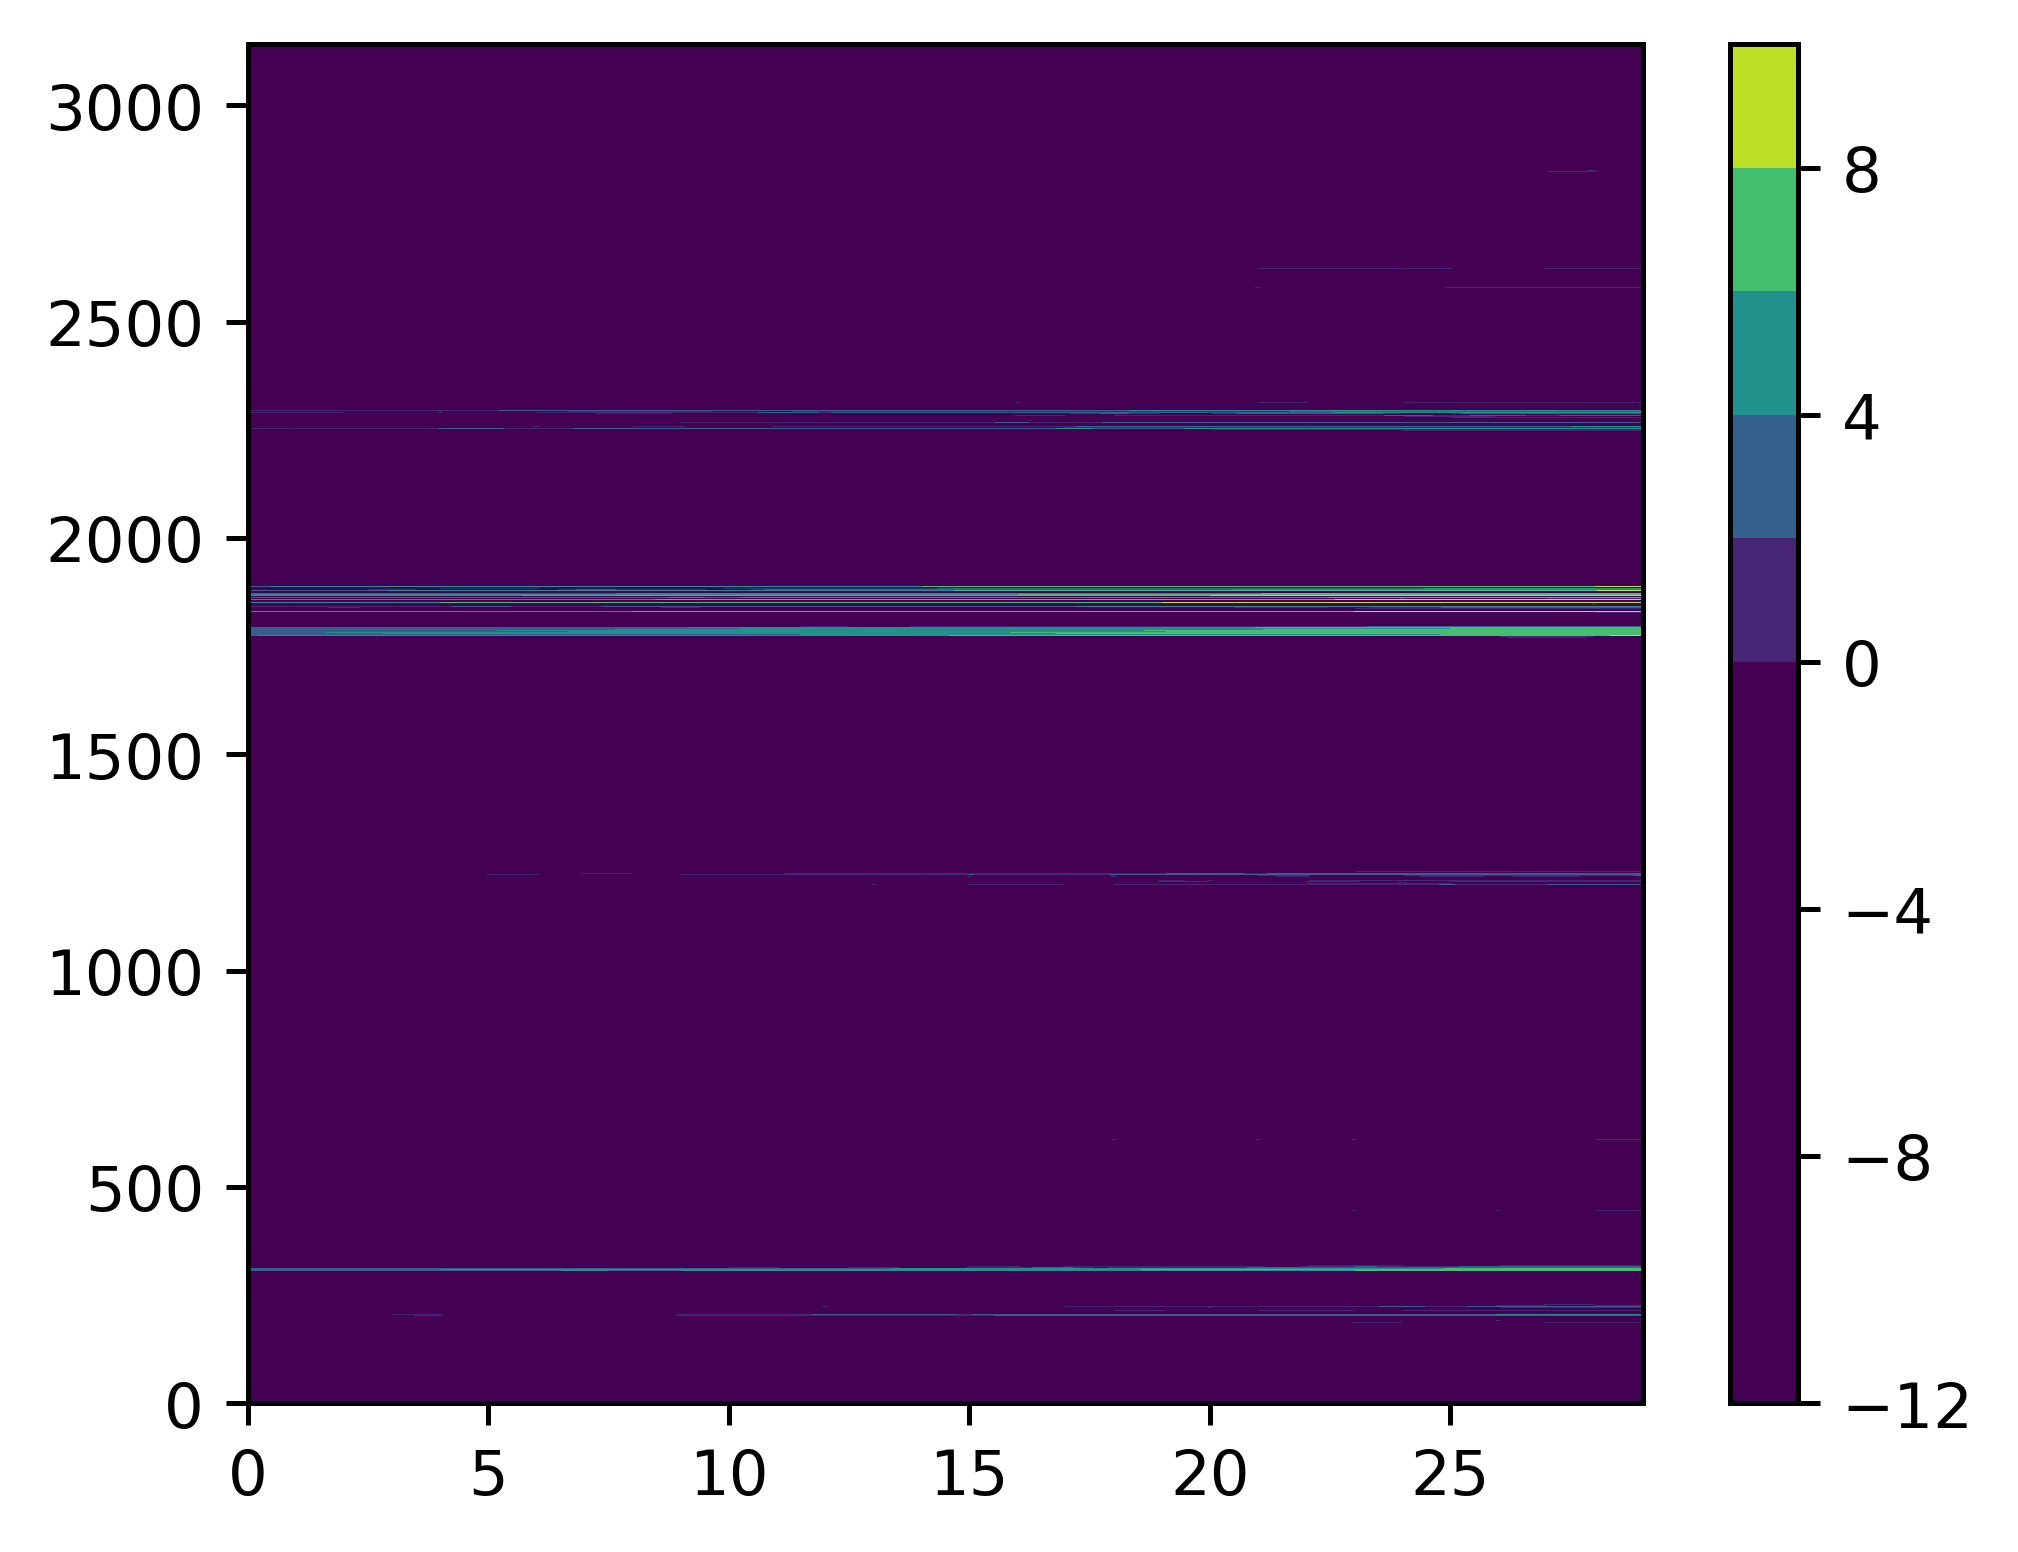

In [73]:
x = np.array(range(30))
y = np.array(range(3142))

X, Y = np.meshgrid(x, y)

g_i[g_i == 0] = 0.00001
Z = np.log(g_i[:,30:])
# Z = g_i[:,30:]

fig1, ax2 = plt.subplots(figsize=(5, 4), dpi=450)
contour = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.viridis,vmin=0) #vmax=36

# contour = ax2.imshow(Z,cmap=plt.cm.coolwarm)

# Add colorbar
cbh = plt.colorbar(contour, orientation='vertical', pad=0.05)
# cbh.ax.set_yticklabels([10, 50, 100])

In [2]:
R0 = 2.2
rs = np.arange(0.01, 1, 0.02)

In [3]:
WN = np.loadtxt('W_avg.csv') ### numpy arrary

In [4]:
# Number of nodes (rows of the matrix)
num_nodes = 3142

# Number of features per node (columns of the matrix)
num_features = 60

# Number of classes
num_classes = 6

# Create a random matrix

In [5]:
# Create a graph from mobility matrix
GM = nx.from_numpy_array(WN)
edges = np.array(GM.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)

In [6]:
### create dictionary of rs and classes 
r_class = dict()
r_class[rs[0]] = (0, 1/rs[0])
r_class[rs[1]] = (1, 1/rs[1])
r_class[rs[2]] = (2, 1/rs[2])
r_class[rs[3]] = (3, 1/rs[3])
for i in range(4,6):
    r_i = rs[i]
    r_class[r_i] = (4, 1/r_i)
for i in range(6,50):
    r_i = rs[i]
    r_class[r_i] = (5, 1/r_i)

In [59]:
matrix.shape

torch.Size([3142, 60])

In [78]:
save_dir = '../../../../../../Volumes/My Passport/branching/branching_results500/'
#### data preparation
Numcounty_mean = np.zeros((50,60)) 
Numcounty_std = np.zeros((50,60))

dataset = []
for r_idx in [0,1,2,3,4,5,6,8,25,49]:
    print(r_idx)
    r = rs[r_idx]
    file_name1 = save_dir + "NewInf_R0-{}_r-{}.npy.gz" .format(np.round(R0,2),np.round(r,2))
    f1 = gzip.GzipFile(file_name1, "r")
    x_i =  np.load(f1)
    real_c = r_class[r][0]
    # Create a list to hold our Data objects
#     print(real_c)
    for g_idx in range(500):
        g_i = x_i[g_idx]
#         g_i[g_i == 0] = 0.00001 ### use the log to make the pattern more obvious
        Z = np.log(g_i[:,30:]) ### previous are almost 0
        matrix = torch.from_numpy(g_i[:,30:])
         
        # Compute the min and max of the features for each node.
#         min_vals, _ = torch.min(matrix, dim=0)
#         max_vals, _ = torch.max(matrix, dim=0)

        # Apply Min-Max normalization.
#         ma_normalized = (matrix - min_vals) / (max_vals - min_vals)

        # Each graph is associated with a random target (0 or 1)
        y = torch.tensor([real_c], dtype=torch.long)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, y=y)
#         data = Data(x=ma_normalized, edge_index=edge_index, y=y)
        data.x = data.x.float()
        data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0


/var/folders/vx/g_l159t12yb63094n730n4pm0000gn/T/ipykernel_78527/3075392601.py:19: RuntimeWarning: divide by zero encountered in log
  Z = np.log(g_i[:,30:]) ### previous are almost 0


1
2
3
4
5
6
8
25
49


In [51]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline fo most o
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128) ### aggreagted, aggreaction function properly, 
        ## this change the mean of the neighbour 
        ## example we can do contact all the values 
        # if we change this function we can get higher order interaction for free
        self.conv2 = GCNConv(128, 64)
        self.classifier = Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x) ### 
#         x = F.dropout(x, p=0.5, training=self.training)

        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training) ### sometimes i do not need the dropout
        ## avoid the local minimal too high here the loss function can be smoothy

        # Global Pooling (mean)
        x = global_mean_pool(x, batch)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

In [79]:
# Now we can create a DataLoader
myloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=30, num_classes=6).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [57]:
def train():
    model.train()
    loss_all = 0
    correct = 0
    total = 0
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() # 清空梯度
        output = model(data) # 前向计算
        label = data.y.to(device)
        # Cross entropy loss
        loss = F.cross_entropy(output, label)
        loss.backward() # 反向传播
        loss_all += data.num_graphs * loss.item()
        optimizer.step()  # 更新参数
        _, predicted = torch.max(output, 1)  # Change "outputs" to "output"
        total += label.size(0)  # Change "labels" to "label"
        correct += (predicted == label).sum().item()  # Change "labels" to "label"
    accuracy = 100 * correct / total
    return loss_all / len(myloader.dataset), accuracy

In [80]:
loss_ep = []
ac_ep = []
for epoch in range(100):
    loss,ac = train()
    loss_ep.append(loss)
    ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}, ac: {:.5f}'.format(epoch, loss, ac))

Epoch: 000, Loss: 1.27854, ac: 48.88000
Epoch: 001, Loss: 0.79584, ac: 65.54000
Epoch: 002, Loss: 0.75479, ac: 68.10000
Epoch: 003, Loss: 0.76106, ac: 66.80000
Epoch: 004, Loss: 0.75880, ac: 68.22000
Epoch: 005, Loss: 0.69025, ac: 70.76000
Epoch: 006, Loss: 0.72061, ac: 68.78000
Epoch: 007, Loss: 0.67588, ac: 71.04000
Epoch: 008, Loss: 0.63940, ac: 72.38000
Epoch: 009, Loss: 0.74180, ac: 67.52000
Epoch: 010, Loss: 0.64629, ac: 72.10000
Epoch: 011, Loss: 0.64169, ac: 71.56000
Epoch: 012, Loss: 0.62695, ac: 72.58000
Epoch: 013, Loss: 0.65617, ac: 71.48000
Epoch: 014, Loss: 0.62787, ac: 72.54000
Epoch: 015, Loss: 0.65064, ac: 71.18000
Epoch: 016, Loss: 0.70618, ac: 69.12000
Epoch: 017, Loss: 0.62930, ac: 72.70000
Epoch: 018, Loss: 0.64784, ac: 72.26000
Epoch: 019, Loss: 0.62428, ac: 72.64000
Epoch: 020, Loss: 0.64745, ac: 71.46000
Epoch: 021, Loss: 0.63022, ac: 72.08000
Epoch: 022, Loss: 0.63311, ac: 72.66000
Epoch: 023, Loss: 0.65747, ac: 72.04000
Epoch: 024, Loss: 0.69054, ac: 70.02000
